# 一、 定价模式分析（Pricing Model Analysis）

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/7004-texi/nyc_taxi_part_1_with_coords.csv')
df_train.head()

,Unnamed: 0,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
0,0,2,2024-01-03T19:42:57.000,2024-01-03T20:15:55.000,1.0,16.67,1.0,N,132,165,...,5.00,0.00,1.0,73.55,0.0,1.75,40.642948,-73.779373,40.618882,-73.965489
1,1,2,2024-01-03T18:43:26.000,2024-01-03T18:43:29.000,2.0,0.01,5.0,N,95,95,...,17.54,0.00,1.0,105.23,0.0,0.00,40.723101,-73.846613,40.723101,-73.846613
2,2,2,2024-01-03T17:00:52.000,2024-01-03T17:01:05.000,2.0,0.00,5.0,N,265,265,...,0.00,0.00,1.0,121.00,0.0,0.00,NaN,NaN,NaN,NaN
3,3,2,2024-01-03T10:00:04.000,2024-01-03T11:08:22.000,1.0,21.60,1.0,N,132,136,...,18.46,6.94,1.0,110.75,0.0,1.75,40.642948,-73.779373,40.872570,-73.902662
4,4,2,2024-01-01T00:01:58.000,2024-01-01T00:10:04.000,3.0,1.70,1.0,N,234,144,...,2.36,0.00,1.0,18.06,2.5,0.00,40.736072,-73.990189,40.722500,-73.994000


In [5]:
fee_columns = ['fare_amount', 'extra', 'mta_tax', 'tip_amount',
               'tolls_amount', 'improvement_surcharge',
               'congestion_surcharge', 'airport_fee']

fee_pct = df_train[fee_columns].sum() / df_train['total_amount'].sum() * 100

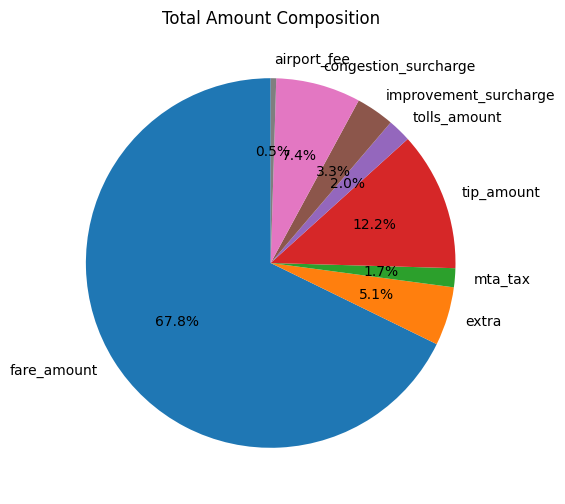

In [6]:
plt.figure(figsize=(10, 6))
plt.pie(fee_pct, labels=fee_pct.index, autopct='%.1f%%', startangle=90)
plt.title('Total Amount Composition')
plt.show()


##(1) Time and cost difference analysis

In [7]:
# Grouped by hour
df_train['tpep_pickup_datetime'] = pd.to_datetime(df_train['tpep_pickup_datetime'])
df_train['hour'] = df_train['tpep_pickup_datetime'].dt.hour
hourly_fees = df_train.groupby('hour')[fee_columns].mean()# Average cost data grouped by hour

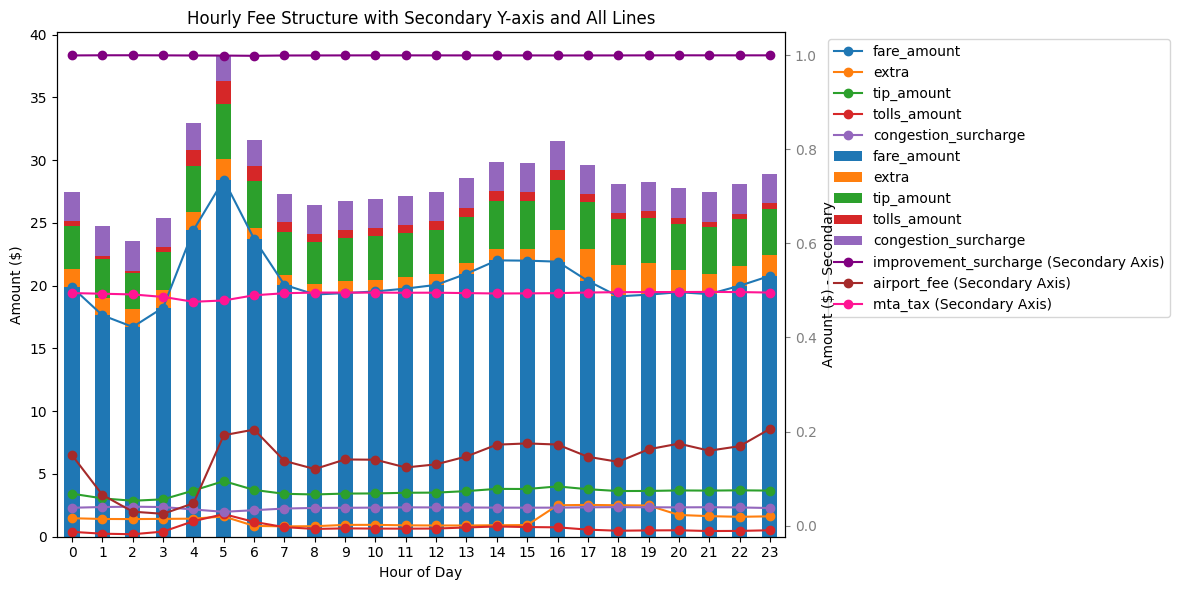

In [8]:
#Plot the primary expense on the primary y-axis on the left, and the low-percentage expense on the secondary y-axis on the right

plt.figure(figsize=(12, 6))
ax1 = hourly_fees[['fare_amount', 'extra', 'tip_amount', 'tolls_amount', 'congestion_surcharge']].plot(kind='bar', stacked=True, ax=plt.gca()) # 移除 mta_tax

ax2 = ax1.twinx()
for column in hourly_fees.columns:
    if column not in ['improvement_surcharge', 'airport_fee', 'mta_tax']:
         ax1.plot(hourly_fees.index, hourly_fees[column], marker='o', linestyle='-', label=column)

line_imp = ax2.plot(hourly_fees.index, hourly_fees['improvement_surcharge'], marker='o', linestyle='-', color='purple', label='improvement_surcharge (Secondary Axis)')[0]
line_airport = ax2.plot(hourly_fees.index, hourly_fees['airport_fee'], marker='o', linestyle='-', color='brown', label='airport_fee (Secondary Axis)')[0]
line_mta = ax2.plot(hourly_fees.index, hourly_fees['mta_tax'], marker='o', linestyle='-', color='deeppink', label='mta_tax (Secondary Axis)')[0] # 添加 mta_tax

ax1.set_title('Hourly Fee Structure with Secondary Y-axis and All Lines')
ax1.set_ylabel('Amount ($)')
ax1.set_xlabel('Hour of Day')
ax1.tick_params(axis='x', rotation=0)

ax2.set_ylabel('Amount ($) - Secondary')
ax2.tick_params(axis='y', colors='gray')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2 = [line_imp, line_airport, line_mta]
labels2 = [line_imp.get_label(), line_airport.get_label(), line_mta.get_label()]

ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## (2)Regional and cost difference  analysis

In [11]:
# Count the occurrences of each pulocationid and find the top 10 popular areas
top_locations_counts = df_train['pulocationid'].value_counts().nlargest(10)
print("Top 10 Pickup Locations and their counts:")
print(top_locations_counts)

Top 10 Pickup Locations and their counts:
pulocationid
237    485925
132    465006
161    464113
236    436030
162    352516
142    341079
138    330354
230    328452
186    325568
163    298589
Name: count, dtype: int64


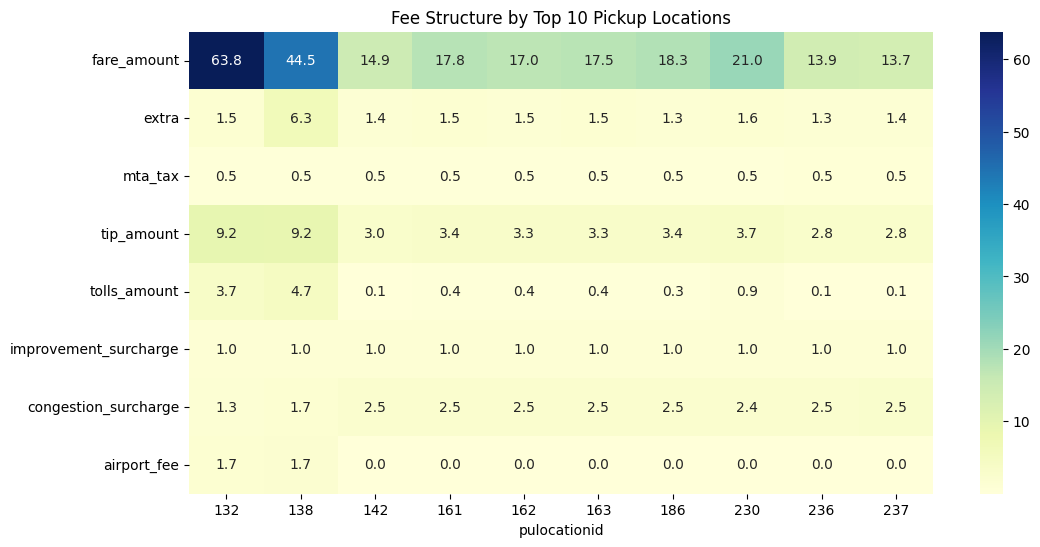

In [12]:
# Analyze the Cost Structure of the Top 10 Pick-up Areas
top_locations = top_locations_counts.index
location_fees = df_train[df_train['pulocationid'].isin(top_locations)].groupby('pulocationid')[fee_columns].mean()
# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(location_fees.T, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Fee Structure by Top 10 Pickup Locations')
plt.show()

'''The color intensity of the cell indicates the average amount for that area under the specific fee type. The darker the color (e.g., more blue), the higher the fee for that area. The lighter the color (e.g., more yellow), the lower the fee for that area.
It is possible to visually compare the differences in various cost compositions among different popular areas.

##（(3) Dual grouping of time and space

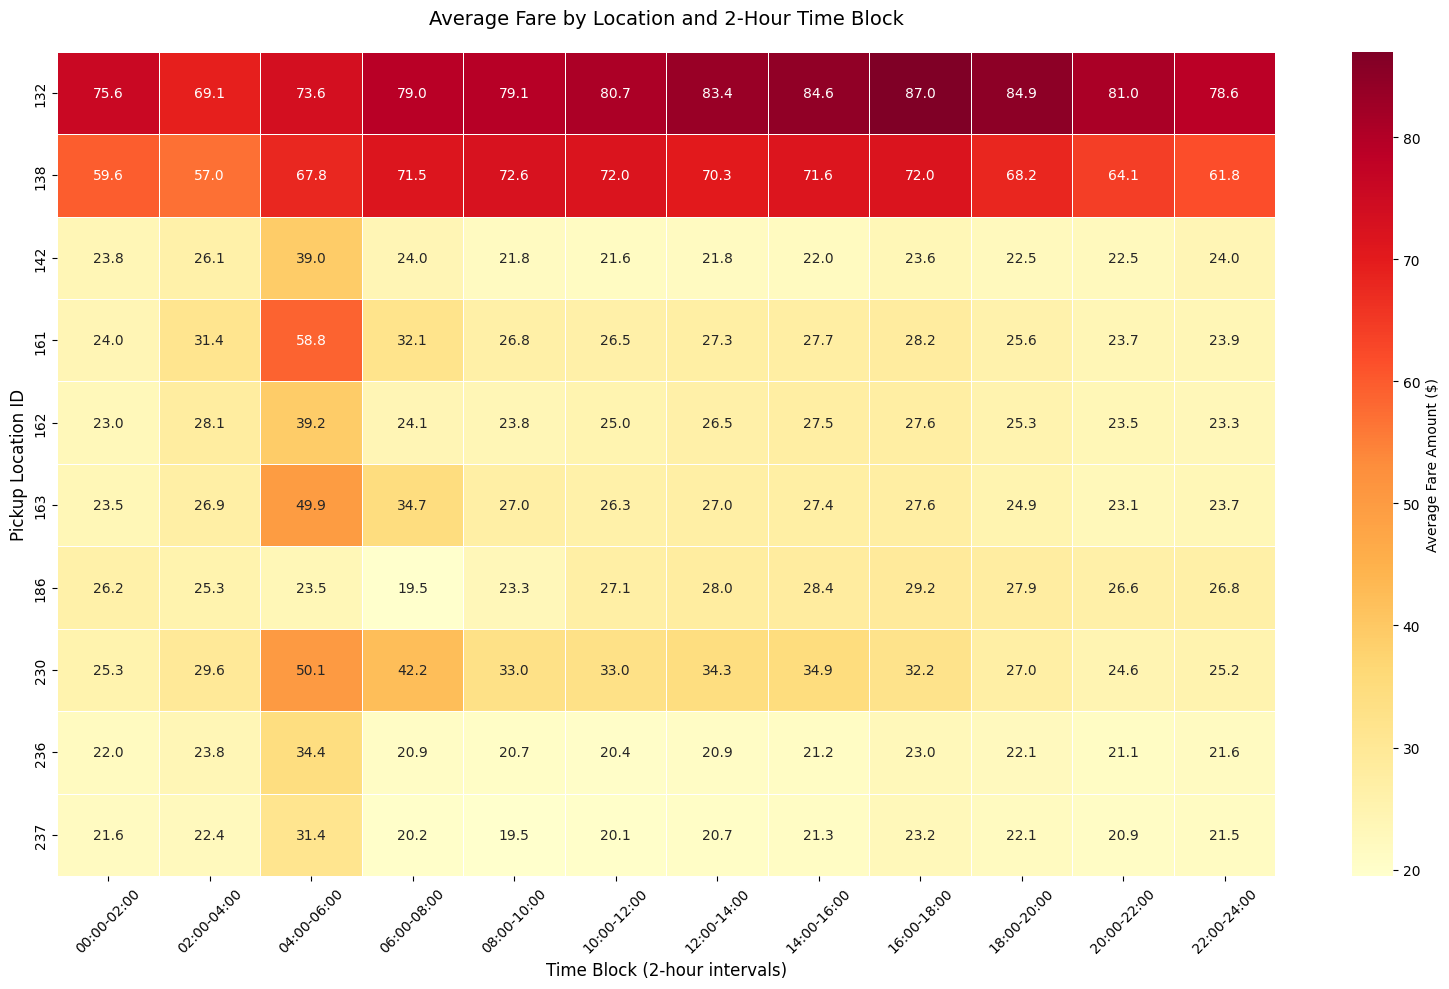

In [19]:
time_labels = [
    '00:00-02:00', '02:00-04:00', '04:00-06:00',
    '06:00-08:00', '08:00-10:00', '10:00-12:00',
    '12:00-14:00', '14:00-16:00', '16:00-18:00',
    '18:00-20:00', '20:00-22:00', '22:00-24:00'
]
df_train['time_block_2h'] = pd.cut(
    df_train['hour'],
    bins=range(0, 25, 2),
    labels=time_labels,
    right=False
)
top_locations = df_train['pulocationid'].value_counts().nlargest(10).index
top10_locations = df_train[df_train['pulocationid'].isin(top_locations)]

pivot_fees = top10_locations.pivot_table(
    index='pulocationid',
    columns='time_block_2h',
    values='total_amount',
    aggfunc='mean'
)
pivot_fees = pivot_fees[time_labels]
plt.figure(figsize=(16, 10))
sns.heatmap(
    pivot_fees,
    cmap='YlOrRd',
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={'label': 'Average Fare Amount ($)'}
)

plt.title('Average Fare by Location and 2-Hour Time Block', pad=20, fontsize=14)
plt.xlabel('Time Block (2-hour intervals)', fontsize=12)
plt.ylabel('Pickup Location ID', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Animation display

In [16]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

df_train['hour'] = pd.to_datetime(df_train['tpep_pickup_datetime']).dt.hour
hourly_fees = df_train.groupby(['pulocationid', 'hour'])['total_amount'].mean().unstack()
nyc_bbox = {'min_lon': -74.3, 'max_lon': -73.7, 'min_lat': 40.5, 'max_lat': 40.90}

try:
    nyc_map_zoom = plt.imread('/content/drive/MyDrive/Colab Notebooks/7004-texi/nyc_map_b.png')
except FileNotFoundError:
    print("Error: nyc_map_b.png not found. Please check the file path.")
    nyc_map_zoom = None

fig, ax = plt.subplots(figsize=(8, 6))
def update(hour):
    ax.clear()
    ax.set_xlim(nyc_bbox['min_lon'], nyc_bbox['max_lon'])
    ax.set_ylim(nyc_bbox['min_lat'], nyc_bbox['max_lat'])
    ax.set_title(f'Hour {hour:02d}:00 - Average Fare Heatmap')
    if nyc_map_zoom is not None:
        ax.imshow(nyc_map_zoom,
                  zorder=0,
                  extent=[nyc_bbox['min_lon'], nyc_bbox['max_lon'], nyc_bbox['min_lat'], nyc_bbox['max_lat']],
                  aspect='auto')

    # hourly_fees
    current_hour_data = hourly_fees[hour].reset_index()
    current_hour_data.rename(columns={hour: 'average_total_amount'}, inplace=True)

    # location
    location_coords = df_train[['pulocationid', 'pickup_lon', 'pickup_lat']].drop_duplicates()

    # merge
    current_data = location_coords.merge(
        current_hour_data, on='pulocationid', how='left'
    )

    sc = ax.scatter(
        x=current_data['pickup_lon'],
        y=current_data['pickup_lat'],
        c=current_data['average_total_amount'],
        cmap='OrRd',
        s=50,
        alpha=1.0,
        edgecolors='k',
        linewidths=0.5,
        zorder=1
    )

    if not hasattr(ax, 'colorbar'):
        ax.colorbar = plt.colorbar(sc, ax=ax, label='Average Fare ($)')
    else:
        ax.colorbar.update_normal(sc)
    # ax.grid(True, alpha=0.3)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

ani = FuncAnimation(fig, update, frames=range(24), interval=500)
plt.close(fig)
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.